In [1]:
import cv2
from numpy import asarray, savez_compressed, load, expand_dims, save
from PIL import Image
from matplotlib import pyplot as plt
import albumentations as A
import os 
from keras.models import load_model
import mtcnn
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder, Normalizer
from sklearn.svm import SVC
os.environ['KMP_DUPLICATE_LIB_OK']='True'

Using TensorFlow backend.
D:\Programming\ML\FYP_PROJECT\myenv\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
D:\Programming\ML\FYP_PROJECT\myenv\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
D:\Programming\ML\FYP_PROJECT\myenv\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
D:\Programming\ML\FYP_PROJECT\myenv\lib\site-pa

In [2]:
def extract_face(filename, required_size=(160,160)):
    # load image from file
    image = cv2.imread(filename)
    # convert to RGB, if needed
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # convert to array
    pixels = asarray(image)
    # create the detector using default weights
    detector = mtcnn.MTCNN()
    # detect faces in the image
    results = detector.detect_faces(pixels)
    face_array = []
    # extract the bounding box from the first face
    for res in results:
        print(res)
        x1, y1, width, height = res['box']
        # confidence
        confidence = res['confidence']
        # bug fix
        x1, y1 = abs(x1), abs(y1)
        x2, y2 = x1+width, y1+height
        # greater than 0.95
        if confidence > 0.85:
            # extract the face
            face = pixels[y1:y2, x1:x2]
            image = Image.fromarray(face)
            image = image.resize(required_size)
            face_array.append(asarray(image))
    return face_array

In [58]:
## DON'T RUN THIS
pixels = extract_face('data/train/ahmed/IMG_20210828_100731.jpg')
len(pixels)

0

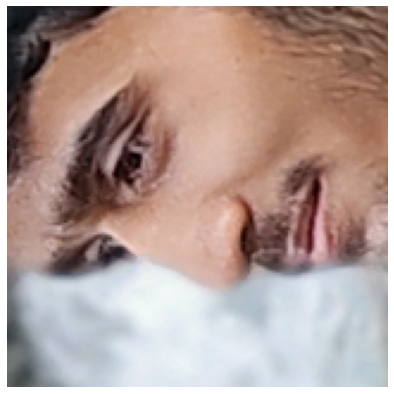

In [53]:
## this for visualization only
i = 1
fig = plt.figure(figsize=(10, 7))
for pixel in pixels:
    fig.add_subplot(1,1,i)
    plt.imshow(pixel)
    plt.axis('off')
    i = i + 1

In [3]:
def load_faces(directory):
    faces = list()
    #enumerate files
    for filename in os.listdir(directory):
        # path
        path = os.path.join(directory, filename)
        # get face
        face = extract_face(path)
        # append all faces in an image into new faces array
        for pixel in face:
            faces.append(pixel)
    return faces

In [4]:
## this for self check don't run this
faces = load_faces("data/train/ahmed")
# make subplot setup
print(len(faces))
# i = 1
# for face in faces:
#     fig = plt.figure(figsize=(10, 7))
#     fig.add_subplot(1,14,i)
#     plt.imshow(face)
#     plt.axis('off')
# i = i + 1

14


In [20]:
## don't run this
img = cv2.imread("data/train/ahmed/IMG_20210828_100731.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img.shape

(1440, 1080, 3)

In [ ]:
## don't run this
transform = alb.Compose([
    A.HorizontalFlip(p=0.5),
    A.ShiftScaleRotate(p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.Rotate(),
    A.Flip(),
    A.Transpose(),
    A.OneOf([
            A.MotionBlur(p=0.2),
            A.MedianBlur(blur_limit=3, p=0.1),
            A.Blur(blur_limit=3, p=0.1),
        ], p=0.2),
    A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=45, p=0.2),
])

In [101]:
## don't run this
def visualize(image):
    plt.figure(figsize=(2, 2))
    plt.axis('off')
    plt.imshow(image)

In [ ]:
## don't run this
faces = load_faces("data/train/ahmed")
# make subplot setup
new_faces = faces
print(len(new_faces))
for face in faces:
    for i in range(10):
        transformed = transform(image=face)
        new_faces.append(transformed['image'])

len(new_faces)

In [9]:
# load a dataset that contains one subdir  for each class that in turn contains images
def load_dataset(dir_):
    X, y = list(), list()
    # enumerate folders, on per class
    for subdir in os.listdir(dir_):
        # path
        path = os.path.join(dir_, subdir)
        # skip any files that might be in the dir
        if not os.path.isdir(path):
            continue
        # load all faces in the subdirectory
        faces = load_faces(path)
        # create labels 
        labels = [subdir for _ in range(len(faces))]
        # summarize progress
        print(f"loaded {len(faces)} examples for class {subdir}")
        # store
        X.extend(faces)
        y.extend(labels)
    return asarray(X), asarray(y)

In [10]:
# load train dataset
trainX, trainy = load_dataset("data/train")
print(trainX.shape, trainy.shape)

loaded 14 examples for class ahmed
loaded 14 examples for class ben_afflek
loaded 18 examples for class elton_john
loaded 22 examples for class jerry_seinfeld
loaded 18 examples for class madonna
loaded 22 examples for class mindy_kaling
(108, 160, 160, 3) (108,)


In [11]:
testX, testy = load_dataset("data/val")

loaded 12 examples for class ahmed
loaded 5 examples for class ben_afflek
loaded 6 examples for class elton_john
loaded 6 examples for class jerry_seinfeld
loaded 5 examples for class madonna
loaded 5 examples for class mindy_kaling


NameError: name 'savez_compressed' is not defined

In [15]:
savez_compressed('data.npz', trainX, trainy, testX, testy)

In [6]:
from keras.models import load_model
# load the model
model = load_model('facenet_keras.h5')
# summarize input and output shape
print(model.inputs)
print(model.outputs)

[<tf.Tensor 'input_1_2:0' shape=(?, 160, 160, 3) dtype=float32>]
[<tf.Tensor 'Bottleneck_BatchNorm_2/cond/Merge:0' shape=(?, 128) dtype=float32>]


In [4]:
def get_embedding(model, face_pixels):
    # scale pixel values
    face_pixels = face_pixels.astype('float32')
    #standardize pixel values across channesl (global)
    mean, std = face_pixels.mean(), face_pixels.std()
    face_pixels = (face_pixels-mean)/std
    # transform face into one sample
    samples = expand_dims(face_pixels, axis=0)
    # make prediction to get embedding
    yhat = model.predict(samples)
    return yhat[0]

In [17]:
# load the face dataset
data = load('data.npz')
trainX, trainy, testX, testy = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']
print(f"Loaded: {trainX.shape, trainy.shape, testX.shape, testy.shape}")
# load the facenet model
model = load_model('facenet_keras.h5')
# convert each face in the train set to an embedding
newTrainX = list()
for face_pixels in trainX:
    embedding = get_embedding(model,face_pixels)
    newTrainX.append(embedding)
newTrainX = asarray(newTrainX)
print(newTrainX.shape)
# convert each face in the test set to an embedding
newTestX = list()
for face_pixels in testX:
    embedding = get_embedding(model,face_pixels)
    newTestX.append(embedding)
newTestX = asarray(newTestX)
print(newTestX.shape)

Loaded: ((108, 160, 160, 3), (108,), (39, 160, 160, 3), (39,))
(108, 128)
(39, 128)


In [18]:
savez_compressed('face_embeddings.npz', newTrainX, trainy, newTestX, testy)

In [20]:
data = load('face_embeddings.npz')
trainX, trainy, testX, testy = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']
print(f"Dataset: train={trainX.shape[0], testX.shape[0]}")
#normalize input vectors
in_encoder = Normalizer(norm='l2')
trainX = in_encoder.transform(trainX)
testX = in_encoder.transform(testX)
# label encode targets
out_encoder = LabelEncoder()
out_encoder.fit(trainy)
trainy = out_encoder.transform(trainy)
testy = out_encoder.transform(testy)
save('classes.npy', out_encoder.classes_)
# fit model
model = SVC(kernel='linear', probability=True)
model.fit(trainX, trainy)
# predict
yhat_train = model.predict(trainX)
yhat_test = model.predict(testX)
# score
score_train = accuracy_score(trainy, yhat_train)
score_test = accuracy_score(testy, yhat_test)
# summarize
print(f"Accuracy: train={score_train*100}, test={score_test*100}")

Dataset: train=(108, 39)
Accuracy: train=99.07407407407408, test=94.87179487179486


In [52]:
import pickle
filename = 'finalized_model.sav'
pickle.dump(model, open(filename, 'wb'))
 
# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
class_ = loaded_model.predict([trainX[15]])
yhat_prob = loaded_model.predict_proba([trainX[15]])
cl = class_[0]
cla_prob = yhat_prob[0, class_]*100
cla_prob, cl, yhat_prob

(array([85.16665681]),
 1,
 array([[0.01448835, 0.85166657, 0.0368302 , 0.0516618 , 0.01514644,
         0.03020664]]))

In [29]:
testy

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2,
       2, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5])

In [30]:
yhat_test == testy

array([ True,  True,  True,  True,  True,  True,  True,  True, False,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
       False,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True])

In [4]:
pixels = extract_face('testing_data/ahmed.jpg')

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
{'box': [264, 491, 36, 54], 'confidence': 0.9554527997970581, 'keypoints': {'left_eye': (287, 510), 'right_eye': (298, 510), 'nose': (301, 521), 'mouth_left': (287, 532), 'mouth_right': (295, 532)}}


In [5]:
model1 = load_model('facenet_keras.h5')
# convert each face in the train set to an embedding
newTrainX = list()
# for face_pixels in pixels:
embedding = get_embedding(model1,pixels[0])
newTrainX.append(embedding)
newTrainX = asarray(newTrainX)
print(newTrainX.shape)





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.




D:\Programming\ML\FYP_PROJECT\myenv\lib\site-packages\keras\models.py:252: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


(1, 128)


In [6]:
# normalize input vectors
in_encoder = Normalizer(norm='l2')
trainX = in_encoder.transform(newTrainX)

In [7]:
import pickle
filename = 'finalized_model.sav'
# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
class_ = loaded_model.predict(trainX)
yhat_prob = loaded_model.predict_proba(trainX)
encoder = LabelEncoder()
encoder.classes_ = load('classes.npy')
predict_names = encoder.inverse_transform(class_)
cl = class_[0]
cla_prob = yhat_prob[0, class_]*100
predict_names

array(['ahmed'], dtype='<U14')

In [2]:
import pickle
filename = 'finalized_model.sav'
model = pickle.load(open(filename, 'rb'))
encoder = LabelEncoder()
encoder.classes_ = load('classes.npy')

In [3]:
face_embedded_model = load_model('facenet_keras.h5')





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.




D:\Programming\ML\FYP_PROJECT\myenv\lib\site-packages\keras\models.py:252: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [65]:
def run(filename, required_size=(160,160)):
    img = cv2.imread(filename)
    image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    pixels = asarray(image)
    detector = mtcnn.MTCNN()
    results = detector.detect_faces(pixels)
    name = None
    conf = 0.85
    prob_ =20.00
    for res in results:
        data = list()
        x1, y1, width, height = res['box']
        confidence = res['confidence']
        x1, y1 = abs(x1), abs(y1)
        x2, y2 = x1+width, y1+height
        if confidence > conf:
            # extract the face
            face = pixels[y1:y2, x1:x2]
            image = Image.fromarray(face)
            image = image.resize(required_size)
            data.append(get_embedding(face_embedded_model, asarray(image)))
            data = asarray(data)
            in_encoder = Normalizer(norm='l2')
            dataX = in_encoder.transform(data)
            class_ = model.predict(dataX)
            yhat_prob = model.predict_proba(dataX)
            predict_names = encoder.inverse_transform(class_)
            prob = yhat_prob[0, class_]*100
            if prob[0] > prob_:
                print(prob[0])
                name = predict_names
                cv2.rectangle(img, (x1, y1), (x2, y2), (255, 0, 0), thickness=1)
                cv2.putText(img, f'{name}', (x1, y1), cv2.FONT_ITALIC, 1, (0, 0, 255), 1)
    cv2.imshow('faces', img)
    cv2.waitKey(0)

In [66]:
run("testing_data/ahmed.jpg")

30.787022570089313
30.787022570089313
